In [115]:
# Импортируем все необходиме модули
# pandas -- для создания датафреймов, как в r, в питоне
# os -- для того, чтобы обращаться к папкам и вообще работать с файловой системой
# seaborn -- для того, чтобы делать красивые картинки
# matplotlib -- этот модуль нужен для seaborn

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [120]:
# Напишем функцию, которая будет загружать наш датасет и добавлять необходимые
# колонки для построения графика

def make_proper_df(df_name):
    # Смотрим, где мы
    where_am_i = os.getcwd()
    # Грузим в df наш датасет
    df = pd.read_csv(os.path.join(where_am_i, df_name), sep='\t')
    # Добавляем в наш df три столбика
    # ase_normal -- процент АСЭ генов в норме
    # ase_tumor -- процент АСЭ генов в опухоли
    # total -- по сути везде пишется 100 % (это нужно для построения графика, 
    # никакой смысловой нагрузки этот столик не несет)
    df['ase_normal'] = df.count_normal/df.total_normal * 100
    df['ase_tumor'] = df.count_tumor/df.total_tumor * 100
    df['total'] = df.total_normal/df.total_normal * 100
    return df

In [121]:
df = make_proper_df('statistics_ext.tsv')
df

,gene,average_normal,median_normal,stdev_normal,count_normal,total_normal,average_tumor,median_tumor,stdev_tumor,count_tumor,total_tumor,ase_normal,ase_tumor,total
0,A1BG,0.530000,0.530,0.000651,2,6,0.640000,0.640,0.039325,4,6,33.333333,66.666667,100.0
1,A1CF,0.800000,0.860,0.111923,8,46,0.720000,0.690,0.091922,8,41,17.391304,19.512195,100.0
2,ABCB11,0.650000,0.610,0.110131,5,30,0.650000,0.650,0.036160,6,30,16.666667,20.000000,100.0
3,ABCB4,0.620000,0.620,NaN,1,36,0.810000,0.810,0.088890,3,36,2.777778,8.333333,100.0
4,ACOT12,0.730000,0.730,NaN,1,11,0.840000,0.840,0.023768,2,11,9.090909,18.181818,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,WRN,0.880000,0.880,NaN,1,25,0.815000,0.815,0.035355,2,30,4.000000,6.666667,100.0
253,XPC,0.715000,0.715,0.035355,2,74,0.749091,0.760,0.076479,11,71,2.702703,15.492958,100.0
254,YWHAE,0.876667,0.885,0.033862,6,17,0.781667,0.810,0.120236,6,16,35.294118,37.500000,100.0
255,ZFHX3,0.850000,0.850,NaN,1,38,0.767143,0.750,0.052509,7,58,2.631579,12.068966,100.0


### Сделаем картинку, где будут отображены гены, где частота АСЭ в опухоли выше, чем в норме

In [122]:
# Это то, что будет ИСКЛЮЧЕНО из датасета
# Что исключаем?

# (df.total_normal <= 7) | (df.total_tumor <= 7) -- количество образцов в норме и опухоли,
# которые подавали mbased, больше 7 (число из головы)

# (df.ase_tumor/df.ase_normal <= 2) -- частота АСЭ в опухоли в 2 раза и больше выше,
# чем в норме (просто хотел показать, что таких вариантов очень много)

# (df.ase_normal >= 100) | (df.ase_tumor >= 100) -- это проверка на то, чтобы количество
# АСЭ образцов было НЕ больше, чем тестируемых образцов (такое действительно есть!)

statement = (df.total_normal <= 7) | (df.total_tumor <= 7) | \
    (df.ase_tumor/df.ase_normal <= 2) | (df.ase_normal >= 100) | (df.ase_tumor >= 100)

df = df.drop(df[statement].index)
df = df.reset_index(drop=True)
pd.set_option('display.max_rows', 10)

df

,gene,average_normal,median_normal,stdev_normal,count_normal,total_normal,average_tumor,median_tumor,stdev_tumor,count_tumor,total_tumor,ase_normal,ase_tumor,total
0,ABCB4,0.620000,0.620,NaN,1,36,0.810000,0.81,0.088890,3,36,2.777778,8.333333,100.0
1,AKT1,0.870000,0.870,NaN,1,33,0.870000,0.87,0.008571,2,30,3.030303,6.666667,100.0
2,APCS,0.580000,0.580,0.048774,8,28,0.660000,0.62,0.099754,21,28,28.571429,75.000000,100.0
3,ARHGEF10L,0.786667,0.840,0.092376,3,52,0.815714,0.83,0.077858,7,45,5.769231,15.555556,100.0
4,ARHGEF12,0.860000,0.860,0.020000,3,32,0.787143,0.82,0.098609,7,33,9.375000,21.212121,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,TAT,0.580000,0.540,0.062847,5,23,0.630000,0.59,0.075908,11,23,21.739130,47.826087,100.0
60,TET2,0.850000,0.850,NaN,1,37,0.785000,0.81,0.088129,4,41,2.702703,9.756098,100.0
61,USP8,0.850000,0.850,NaN,1,24,0.840000,0.84,0.038074,7,31,4.166667,22.580645,100.0
62,XPC,0.715000,0.715,0.035355,2,74,0.749091,0.76,0.076479,11,71,2.702703,15.492958,100.0


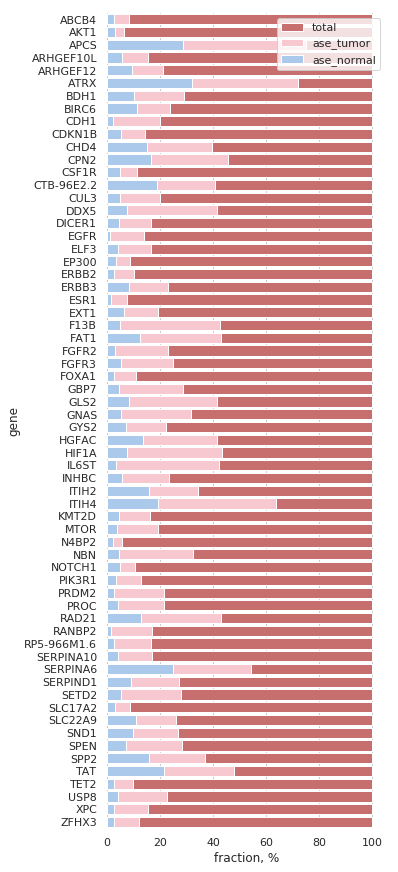

In [86]:
# Создаем картинку вида stacked barplot в seaborn

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(5, 15))

sns.set_color_codes("muted")
sns.barplot(x='total', y="gene", data=df,
            label="total", color="r")

sns.set_color_codes("muted")
sns.barplot(x='ase_tumor', y="gene", data=df,
            label="ase_tumor", color='pink')

sns.set_color_codes("pastel")
sns.barplot(x="ase_normal", y="gene", data = df,
            label="ase_normal", color="b")

ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="gene",
       xlabel="fraction, %")
sns.despine(left=True, bottom=True)

plt.savefig('high_tumor_ase_frequency.png', dpi=400, bbox_inches='tight')

### Теперь сделаем картинку, где отобразим все гены, у которых хотя бы в половине образцов наблюдается АСЭ (и в норме, и в опухоли) + частота АСЭ в опухоли выше, чем в норме

In [123]:
df = make_proper_df('statistics_ext.tsv')
df

,gene,average_normal,median_normal,stdev_normal,count_normal,total_normal,average_tumor,median_tumor,stdev_tumor,count_tumor,total_tumor,ase_normal,ase_tumor,total
0,A1BG,0.530000,0.530,0.000651,2,6,0.640000,0.640,0.039325,4,6,33.333333,66.666667,100.0
1,A1CF,0.800000,0.860,0.111923,8,46,0.720000,0.690,0.091922,8,41,17.391304,19.512195,100.0
2,ABCB11,0.650000,0.610,0.110131,5,30,0.650000,0.650,0.036160,6,30,16.666667,20.000000,100.0
3,ABCB4,0.620000,0.620,NaN,1,36,0.810000,0.810,0.088890,3,36,2.777778,8.333333,100.0
4,ACOT12,0.730000,0.730,NaN,1,11,0.840000,0.840,0.023768,2,11,9.090909,18.181818,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,WRN,0.880000,0.880,NaN,1,25,0.815000,0.815,0.035355,2,30,4.000000,6.666667,100.0
253,XPC,0.715000,0.715,0.035355,2,74,0.749091,0.760,0.076479,11,71,2.702703,15.492958,100.0
254,YWHAE,0.876667,0.885,0.033862,6,17,0.781667,0.810,0.120236,6,16,35.294118,37.500000,100.0
255,ZFHX3,0.850000,0.850,NaN,1,38,0.767143,0.750,0.052509,7,58,2.631579,12.068966,100.0


In [124]:
# Это то, что будет ИСКЛЮЧЕНО из датасета
# Что исключаем?

# Большинство условий такие же, как в предыдущем условии
# (df.ase_tumor/df.ase_normal <= 1.0) -- частота АСЭ в опухоли выше, чем в норме

# (df.count_normal/df.total_normal <= 0.5) | (df.count_tumor/df.total_tumor <= 0.5) -- 
# хотя бы в половине образцов наблюдается АСЭ (и в норме, и в опухоли)

statement2 = (df.total_normal <= 7) | (df.total_tumor <= 7) | (df.count_tumor/df.total_tumor <= 0.5) | \
    (df.count_normal/df.total_normal <= 0.5) | (df.ase_normal >= 100) | (df.ase_tumor >= 100) | \
    (df.ase_tumor/df.ase_normal <= 1.0)
     
df2 = df.drop(df[statement2].index)
df2 = df2.reset_index(drop=True)
pd.set_option('display.max_rows', 10)

df2

,gene,average_normal,median_normal,stdev_normal,count_normal,total_normal,average_tumor,median_tumor,stdev_tumor,count_tumor,total_tumor,ase_normal,ase_tumor,total
0,APOC4,0.630,0.61,0.066887,19,35,0.720000,0.71,0.084196,21,35,54.285714,60.000000,100.0
1,C5,0.660,0.57,0.132268,35,60,0.690000,0.64,0.123469,41,60,58.333333,68.333333,100.0
2,CD74,0.780,0.78,0.051677,20,30,0.790000,0.78,0.049925,21,31,66.666667,67.741935,100.0
3,CFB,0.610,0.57,0.098621,39,63,0.650000,0.63,0.098129,41,63,61.904762,65.079365,100.0
4,CFHR1,0.640,0.59,0.104040,24,29,0.670000,0.66,0.120910,25,29,82.758621,86.206897,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,EIF3E,0.869,0.88,0.024244,10,17,0.869091,0.87,0.022563,11,14,58.823529,78.571429,100.0
9,FGL1,0.590,0.57,0.063602,18,29,0.660000,0.69,0.092194,24,29,62.068966,82.758621,100.0
10,SDHA,0.750,0.75,0.095052,27,51,0.680000,0.67,0.075866,28,44,52.941176,63.636364,100.0
11,SERPINC1,0.570,0.54,0.076693,29,37,0.640000,0.61,0.088967,30,37,78.378378,81.081081,100.0


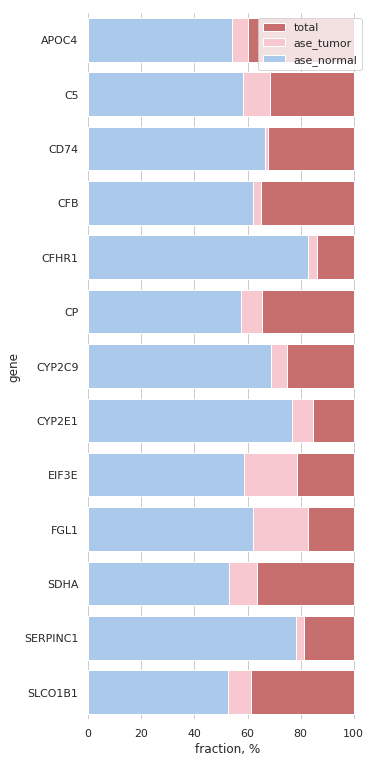

In [127]:
# Делаем картинку

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(5, 13))

sns.set_color_codes("muted")
sns.barplot(x='total', y="gene", data=df2,
            label="total", color="r")

sns.set_color_codes("muted")
sns.barplot(x='ase_tumor', y="gene", data=df2,
            label="ase_tumor", color='pink')

sns.set_color_codes("pastel")
sns.barplot(x="ase_normal", y="gene", data = df2,
            label="ase_normal", color="b")

ax.legend(ncol=1, loc="upper right", frameon=True)
ax.set(ylabel="gene",
       xlabel="fraction, %")
sns.despine(left=True, bottom=True)

plt.savefig('high_ase_frequency.png', dpi=400, bbox_inches='tight')